In [1]:
import re
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from network import select_year, create_edges, adj_matrix, plots

%matplotlib inline

In [2]:
words = select_year('2018')
words.head()

,conf,index,pos,text,tweet
0,0.9889,7,A,poor,1000007326789758987
1,0.9991,8,N,area,1000007326789758987
2,0.9979,13,V,find,1000007326789758987
3,0.9951,17,N,community,1000007326789758987
4,0.9899,18,V,provide,1000007326789758987


In [3]:
w2i, edges = create_edges(words)
edges.head()

,text_x,text_y,counts,number_x,number_y
0,%,day,1,1933,1081
1,%,earnings,1,1933,1282
2,%,find,1,1933,1198
3,%,high,1,1933,1310
4,%,men,1,1933,1948


In [4]:
A = adj_matrix(w2i,edges)
    
# Print out adjacency matrix (weighted)
A

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [5]:
# Triangularize A to avoid edge redundancy
n = A.shape[0]
for i in range(n):
    for j in range(i):
        A[i,j] = 0

In [6]:
# Create an undirected multilink graph object
G = nx.from_numpy_matrix(A, parallel_edges=True, create_using=nx.MultiGraph)

In [7]:
# Get node degrees 
degrees = pd.DataFrame(G.degree)
degrees.shape

(2054, 2)

In [8]:
isolated_nodes = degrees.loc[degrees[1] == 0,0].values
isolated_nodes

array([865])

In [ ]:
# Remove isolated nodes
for node in isolated_nodes:
    G.remove_node(node)

# Get new node degrees 
degrees = pd.DataFrame(G.degree)[1]
degrees.shape

(2053,)

In [ ]:
# Get the unique values of degree and their counts
unique, counts = np.unique(degrees.values, return_counts = True)

In [ ]:
# Compute the pdf of degrees
pdf = counts / np.sum(counts)

In [ ]:
# Compute the cumulative pdf of degrees
cpdf = 1 - np.cumsum(pdf)

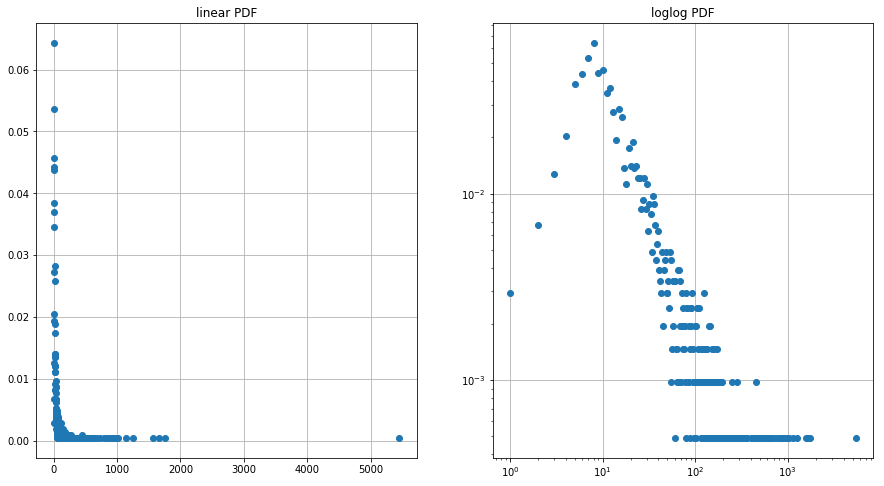

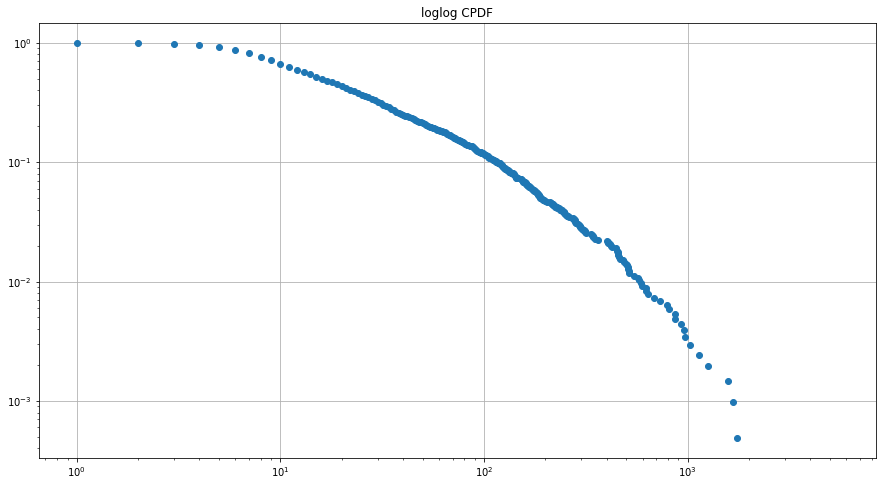

In [ ]:
plots(unique,pdf,cpdf)

In [ ]:
# Min and Max values of degrees
kmin = np.min(unique)
kmax = np.max(unique)

print('kmin: {}, kmax: {}'.format(kmin,kmax))

kmin: 1, kmax: 5453


In [ ]:
# Estrapolate kcut from plot
ksat = 8

In [ ]:
# Estimate power law parameters

gamma = 1 + degrees[ksat:].shape[0]/np.sum(np.log(degrees.values[ksat:] / ksat))
c = (gamma - 1)*ksat**(gamma - 1)
print('Power law estimated parameters')
print('gamma: {}, c: {}'.format(gamma,c))

Power law estimated parameters
gamma: 2.0396160632212395, c: 9.03108309465776


In [ ]:
# Natural cutoff: gamma > 2
ncut = ksat * degrees.shape[0]**(1/(gamma-1))
ncut

12281.618363570962

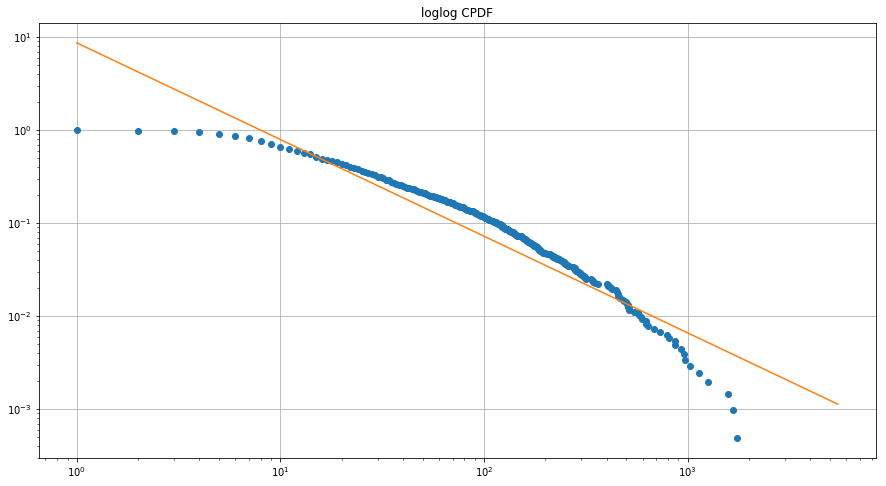

In [ ]:
# Compare the theoretical power law distribution with our network
fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.loglog(unique, cpdf,'o')
ax.set_title('loglog CPDF')
ax.loglog(np.arange(1, np.max(unique)), c * np.arange(1, np.max(unique))**(1-gamma)/(gamma-1))
ax.grid()

plt.show()

In [ ]:
# Extract cardinality of connected component and diameter of the giant component
cc = sorted(nx.connected_components(G),key=len,reverse=True)
for i,x in enumerate(cc):
    print( 'Connected component n.',i+1)
    print( '\tCardinality: {}'.format(len(x)) )
    if not i:
        print( '\tDiameter: {}'.format(nx.diameter(G.subgraph(x))) )

Connected component n. 1
	Cardinality: 2049


In [ ]:
# Convert the multigraph into a weighted graph
Gw = nx.from_pandas_edgelist(edges,source='number_x', target='number_y', edge_attr='counts')

# Compute clustering coefficients
ccoef = pd.Series(nx.clustering(Gw, weight='counts')).reset_index()

plt.figure(figsize=(12,12))
plt.plot(ccoef['index'].values,ccoef[0].values,'gx')
plt.grid()
plt.show()